https://blog.roboflow.com/convert-bboxes-masks-polygons/

# Convert between bounding boxes, polygons and masks

> This is an accompanying notebook for our blog post on this topic, follow along for more details!

**All function inside supervision require integer to work!(mask is exception)**

In [1]:
# Download necessary packages

!pip install roboflow supervision --quiet

## How to Convert a Polygon to Bounding Boxes

In [2]:
import supervision as sv
import numpy as np

def process_label_file(file_path):
    objects = []
    masks_list = []
    polygon_list = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            parts_float = [float(coord) for coord in parts[1:]]
            num_vertices = len(parts_float) // 2
            assert len(parts_float) % 2 == 0, "The number of coordinates should be even."
            
            #Create polygon shape(n x 2 shape)
            polygon = np.array(parts_float).reshape(num_vertices, 2)
            #Convert from polygon to bounding box
            bounding_box = sv.polygon_to_xyxy(polygon)
            #Convert from polygon to mask
            mask = sv.polygon_to_mask((polygon*640).astype(int), (640,640))

            if len(bounding_box) == 4:  # Ensure there are 4 elements in the line
                object_id, x_center, y_center, width, height = map(float, np.concatenate([[float(parts[0])], bounding_box]))
                objects.append([object_id, x_center, y_center, width, height, '', '', '',])  # Leaving area and mass empty
                masks_list.append(mask.astype(bool))
                polygon_list.append(polygon)
    return (objects, masks_list, polygon_list)

object = process_label_file('./Food-9/train/labels/IMG_20231201_125634_jpg.rf.326ae60f4313898d8cf98915db1f0659.txt')
print(object)
print(np.array(object[1]).shape)

([[2.0, 0.05078125, 0.021484375, 0.150390625, 0.115234375, '', '', ''], [1.0, 0.3515625, 0.033203125, 0.7421875, 0.474609375, '', '', ''], [3.0, 0.14453125, 0.388671875, 0.40625, 0.677734375, '', '', ''], [0.0, 0.794921875, 0.4375, 0.927734375, 0.6171875, '', '', ''], [0.0, 0.5703125, 0.42578125, 0.89453125, 0.869140625, '', '', '']], [array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False

### Prepare bounding box annotation data

In [21]:
np_object = np.array(object[0])
id_column = np_object[:, 0].astype(float).astype(int)
annotation_column = np_object[:, 1:5].astype(float) * 640

print(f'np_object:{np_object}')
print(f'id_column:{id_column}')
print(f'annotation_column:{annotation_column}')

np_object:[['2.0' '0.05078125' '0.021484375' '0.150390625' '0.115234375' '' '' '']
 ['1.0' '0.3515625' '0.033203125' '0.7421875' '0.474609375' '' '' '']
 ['3.0' '0.14453125' '0.388671875' '0.40625' '0.677734375' '' '' '']
 ['0.0' '0.794921875' '0.4375' '0.927734375' '0.6171875' '' '' '']
 ['0.0' '0.5703125' '0.42578125' '0.89453125' '0.869140625' '' '' '']]
id_column:[2 1 3 0 0]
annotation_column:[[ 32.5   13.75  96.25  73.75]
 [225.    21.25 475.   303.75]
 [ 92.5  248.75 260.   433.75]
 [508.75 280.   593.75 395.  ]
 [365.   272.5  572.5  556.25]]


### Prepare semengation data

In [16]:
detect = sv.Detections(annotation_column.astype(int), mask=np.array(object[1]), class_id=id_column)
print(f'detect:{detect}')

detect:Detections(xyxy=array([[ 32,  13,  96,  73],
       [225,  21, 475, 303],
       [ 92, 248, 260, 433],
       [508, 280, 593, 395],
       [365, 272, 572, 556]]), mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False

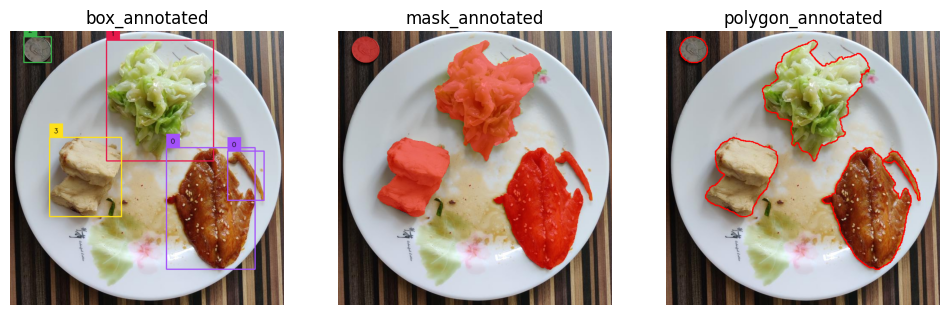

In [19]:
# View the polygon and the bounding box

import cv2
image = cv2.imread("./Food-9/train/images/IMG_20231201_125634_jpg.rf.326ae60f4313898d8cf98915db1f0659.jpg")


poly_annotated = image.copy()
for index, polygon in enumerate(object[2]):
  sv.draw_polygon(
      scene = poly_annotated,
      polygon = (polygon*640).astype(int),
      color = sv.Color.from_hex('ff0000')
  )

box_annotator = sv.BoxAnnotator()
box_annotated = box_annotator.annotate(
    scene = image.copy(),
    detections = detect
)

mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)
mask_annotated = mask_annotator.annotate(
  scene = image.copy(), 
  detections = detect
)

sv.plot_images_grid(
  images = [box_annotated, mask_annotated, poly_annotated],
  grid_size = (1, 3),
  titles = ['box_annotated', 'mask_annotated', 'polygon_annotated']
)

## How to Convert a Polygon to a Mask

In [ ]:
# Get polygon data

from roboflow import Roboflow
import urllib.request
from PIL import Image

rf = Roboflow(api_key="ryx5rUNl1CX3N96J63Ou") # This API key isn't valid. Enter your own API key!
project = rf.workspace().project("goods-segmentation")
model = project.version(1).model

test_image_name = "polygon_test.png"
test_image_url = "https://source.roboflow.com/kpIbBfvfuKOrCNGin1op7bqjR7J2/AdG9AhbeB0eONDnj2cJ4/original.jpg"
urllib.request.urlretrieve(test_image_url, test_image_name)

img = Image.open(test_image_name)
width = img.width
height = img.height

prediction = model.predict("polygon_test.png").json()

classes = list(project.classes)

print(prediction)
print(classes)

detections = sv.Detections.from_roboflow(prediction,classes)
polygons = [sv.detection.utils.mask_to_polygons(m)[0] for m in detections.mask]

loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 156.0, 'y': 290.5, 'width': 80.0, 'height': 131.0, 'confidence': 0.9636580944061279, 'class': 'canned', 'points': [{'x': 116.35000000000001, 'y': 225.55}, {'x': 116.35000000000001, 'y': 342.55}, {'x': 117.0, 'y': 342.55}, {'x': 118.95, 'y': 344.5}, {'x': 118.95, 'y': 345.15000000000003}, {'x': 120.9, 'y': 347.1}, {'x': 120.9, 'y': 347.75}, {'x': 121.55, 'y': 348.40000000000003}, {'x': 121.55, 'y': 349.05}, {'x': 124.15, 'y': 351.65000000000003}, {'x': 124.80000000000001, 'y': 351.65000000000003}, {'x': 125.45, 'y': 352.3}, {'x': 126.75, 'y': 352.3}, {'x': 127.4, 'y': 352.95}, {'x': 130.0, 'y': 352.95}, {'x': 130.65, 'y': 353.6}, {'x': 131.95000000000002, 'y': 353.6}, {'x': 133.25, 'y': 354.90000000000003}, {'x': 134.55, 'y': 354.90000000000003}, {'x': 135.20000000000002, 'y': 355.55}, {'x': 143.0, 'y': 355.55}, {'x': 143.65, 'y': 356.2}, {'x': 165.75, 'y': 356.2}, {'x': 166.4, 'y': 355.55}, {'x': 173.55, '

In [ ]:
# Import Supervision
import supervision as sv

# Import polygon data
detections = sv.Detections.from_roboflow(prediction,classes)

# Export from detections as a mask
masks = detections.mask

print(masks)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  

In [ ]:
# Import Supervision
import supervision as sv

# Convert each polygon in the array of polygons (from detections) to masks
masks = [ sv.polygon_to_mask(polygon,(width,height)) for polygon in polygons ]

print(masks)

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0.

[2 2 2 2 2 1]


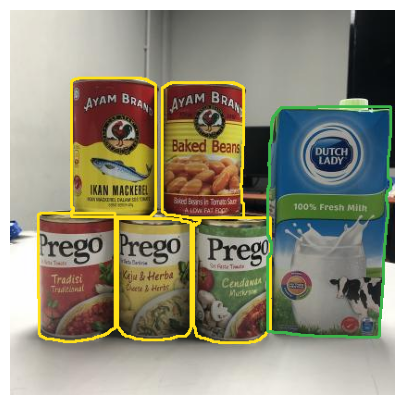

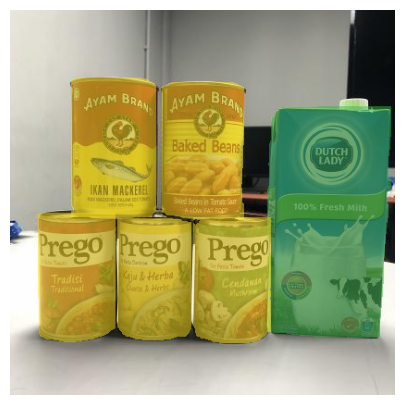

In [ ]:
# View the polygon and the bounding box

import cv2

image = cv2.imread("polygon_test.png")


# Show Polygon
poly_annotated = image.copy()

for index, polygon in enumerate(polygons):
  color = sv.draw.color.DEFAULT_COLOR_PALETTE[detections.class_id[index]]
  sv.draw_polygon(
      scene = poly_annotated,
      polygon = polygon,
      color = sv.Color.from_hex(color)
  )

sv.plot_image(image=poly_annotated, size=(5, 5))

# Show Mask
poly_annotator = sv.MaskAnnotator()

poly_annotated = poly_annotator.annotate(
    scene = image.copy(),
    detections = detections
)

sv.plot_image(image=poly_annotated, size=(5, 5))